# Part 1
#### Importing libraries

In [1]:
import pytz
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.optim import SGD
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from torch.utils.data import Dataset
import time
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from torch.autograd import Variable
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file = '/content/drive/MyDrive/Datasets/MMU-Iris-Database.zip'
extract_folder = '/content/'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Part 2
#### loading train and test data

train_loader:  62  batch
test_loader:  500
index number:  26
Label: 1.0


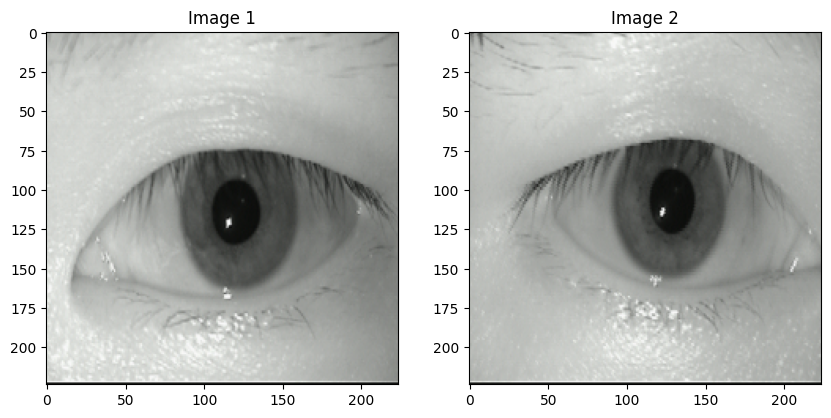

index number:  31
Label: 1.0


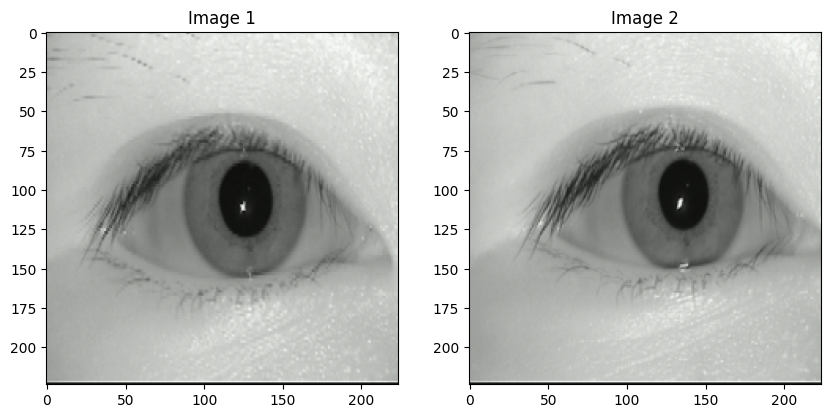

index number:  43
Label: 1.0


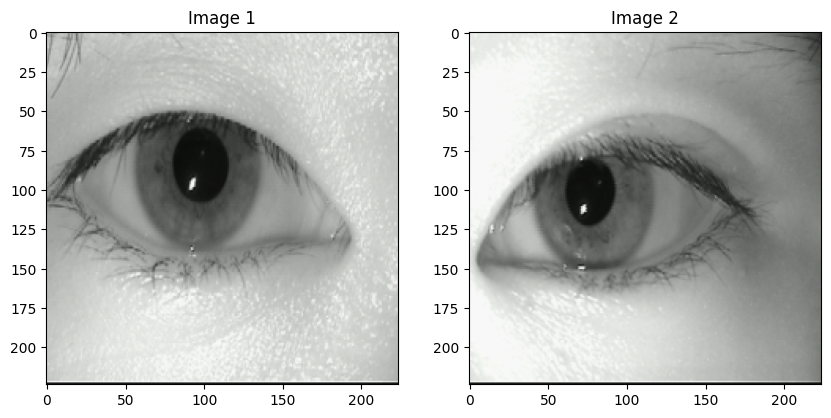

index number:  146
Label: 1.0


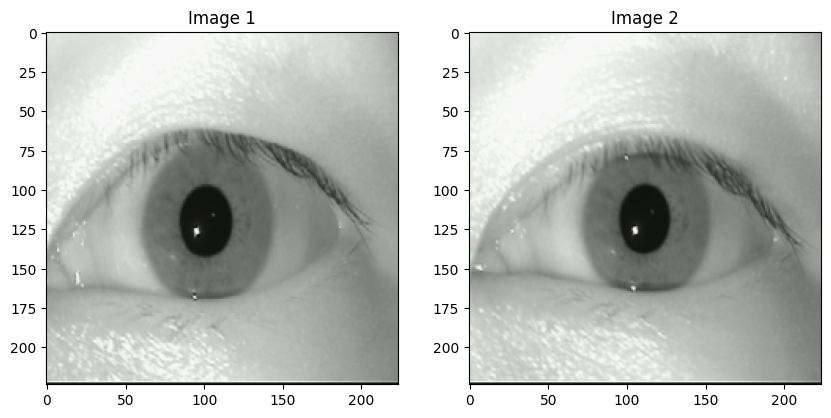

index number:  156
Label: 1.0


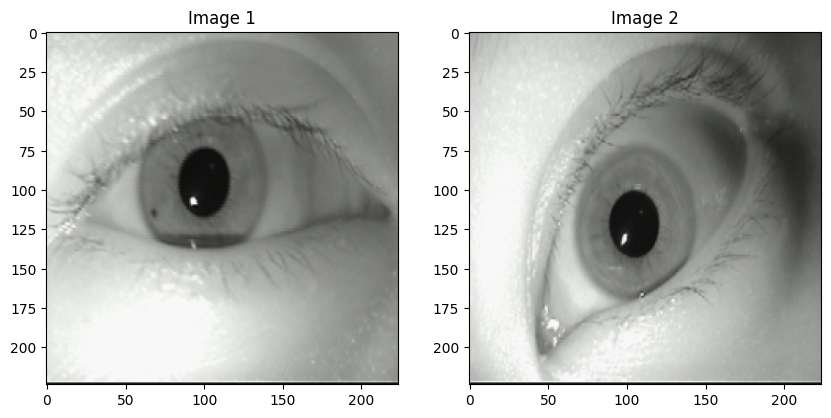

index number:  165
Label: 1.0


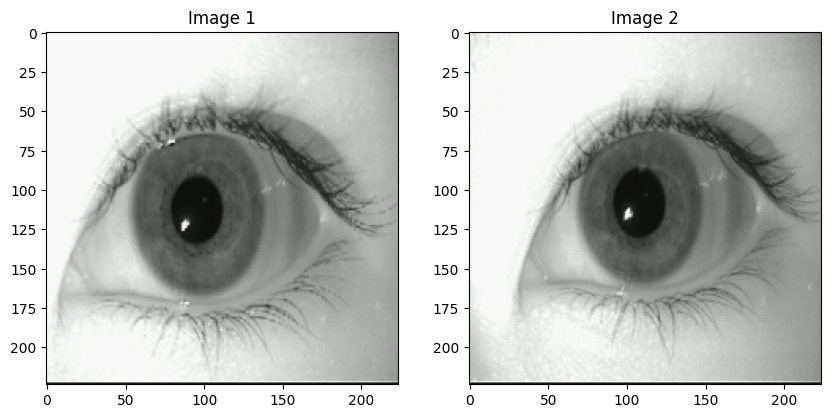

In [4]:
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folders = [os.path.join(root_dir, d) for d in os.listdir(root_dir)]
        self.image_pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        for i, folder in enumerate(self.image_folders):
            images = [os.path.join(folder, img) for img in os.listdir(folder)]
            # Create positive pairs
            for j in range(5):
                pairs.append((images[j], images[j+5], 1))  # Positive pair
            # Create negative pairs
            other_folders = self.image_folders[:i] + self.image_folders[i+1:]
            for other_folder in other_folders:
                other_images = [os.path.join(other_folder, img) for img in os.listdir(other_folder)]
                for j in range(5):
                    pairs.append((images[j], other_images[j], 0))  # Negative pair
        random.shuffle(pairs)
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.image_pairs[idx]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Usage:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
train_dataset = SiameseDataset(root_dir='MMU-Iris-Database/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_dataset = SiameseDataset(root_dir='MMU-Iris-Database/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

print_number = 0
print("train_loader: ",len(train_loader), " batch")
print("test_loader: ",len(test_loader))

# 0 => Negative pair
# 1 => Positive pair
# Get the images and label at index x
for i in range(len(train_dataset)):
    img1, img2, label = train_dataset[i]
    if int(label.item()) == 1:
        print("index number: ",i)
        # Convert tensors to numpy arrays for visualization
        img1 = img1.numpy().transpose((1, 2, 0))
        img2 = img2.numpy().transpose((1, 2, 0))

        # Create a subplot
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Show the images
        axs[0].imshow(img1)
        axs[0].set_title('Image 1')

        axs[1].imshow(img2)
        axs[1].set_title('Image 2')

        # Display the label
        print(f'Label: {label.item()}')

        # Show the plot
        plt.show()
        print_number += 1
        if print_number > 5:
            break

# Part 3
#### Implementing CNN model

In [10]:
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=11, stride=1, padding=5)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu5 = nn.ReLU()
        self.fc1 = nn.Linear(2304, 1000)
        self.fc2 = nn.Linear(1000, 45)

    def forward_one(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.pool1(y)

        y = self.conv2(y)
        y = self.bn2(y)
        y = self.relu2(y)
        y = self.pool2(y)

        y = self.conv3(y)
        y = self.bn3(y)
        y = self.relu3(y)
        y = self.pool3(y)

        y = self.conv4(y)
        y = self.bn4(y)
        y = self.relu4(y)
        y = self.pool4(y)

        y = self.conv5(y)
        y = self.bn5(y)
        y = self.relu5(y)
        y = self.pool5(y)

        y = self.conv6(y)
        y = self.bn6(y)
        y = self.relu6(y)
        y = self.pool6(y)

        y = self.flatten(y)
        y = self.fc1(y)
        y = self.relu5(y)
        y = self.fc2(y)

        return y

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Part 4
#### Creating an object from the model and Implementation of optimizer and loss function

In [11]:
# CNNmodel
model = SiameseModel()
criterion = ContrastiveLoss()
# optimizer
optimizer = SGD(model.parameters(), lr=0.001)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SiameseModel(
  (conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

# Part 5
#### Train Time

In [14]:
train_losses = []
validation_losses = []
best_epoch_number = 0


def train(dataset, validation_dataset, early_stopping_patience=5):
    global best_epoch_number

    all_batches = len(train_loader)
    best_loss = float('inf')
    current_patience = 0
    best_model_state = None
    num_epochs = 100
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        _train_losses = []
        for i, data in enumerate(train_loader, 0):
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs1, outputs2 = model(img1, img2)
            loss = criterion(outputs1, outputs2, labels)
            _train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        # Calculate validation loss
        _validation_losses = []
        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                val_img1, val_img2, val_labels = data
                val_img1, val_img2, val_labels = img1.to(device), img2.to(device), labels.to(device)
                # forward + backward + optimize
                val_outputs1, val_outputs2 = model(val_img1, val_img2)
                val_loss = criterion(val_outputs1, val_outputs2, val_labels)
                _validation_losses.append(val_loss.item())

        avg_validation_loss = sum(_validation_losses) / len(_validation_losses)
        validation_losses.append(avg_validation_loss)

        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_epoch_number = epoch
            best_model_state = model.state_dict()
            current_patience = 0
        else: # when the network loss goes up
            current_patience += 1


        avg_loss = sum(_train_losses) / len(_train_losses)
        train_losses.append(avg_loss)

        # print statistics
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.6f} Validation Loss: {avg_validation_loss:.6f}, Elapsed_time: {elapsed_time:.5f}')

        if current_patience >= early_stopping_patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)
            break
        model.load_state_dict(best_model_state)
    print('Finished Training')

In [15]:
train(train_dataset, test_dataset)

Epoch [1/40], Train Loss: 0.376731 Validation Loss: 0.235423, Elapsed_time: 68.74860
Epoch [2/40], Train Loss: 0.178279 Validation Loss: 0.251715, Elapsed_time: 64.72674
Epoch [3/40], Train Loss: 0.139913 Validation Loss: 0.060436, Elapsed_time: 66.77940
Epoch [4/40], Train Loss: 0.123976 Validation Loss: 0.039702, Elapsed_time: 64.74632
Epoch [5/40], Train Loss: 0.113134 Validation Loss: 0.030753, Elapsed_time: 65.25819
Epoch [6/40], Train Loss: 0.106791 Validation Loss: 0.025155, Elapsed_time: 64.41061
Epoch [7/40], Train Loss: 0.104239 Validation Loss: 0.227478, Elapsed_time: 64.43670
Epoch [8/40], Train Loss: 0.098604 Validation Loss: 0.121684, Elapsed_time: 64.32345
Epoch [9/40], Train Loss: 0.094321 Validation Loss: 0.025922, Elapsed_time: 64.03580
Epoch [10/40], Train Loss: 0.091714 Validation Loss: 0.020392, Elapsed_time: 64.30469
Epoch [11/40], Train Loss: 0.090974 Validation Loss: 0.118497, Elapsed_time: 64.65736
Epoch [12/40], Train Loss: 0.089109 Validation Loss: 0.089369, 

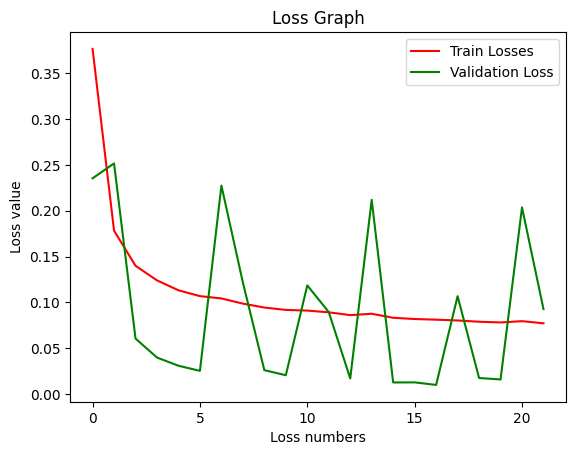

In [16]:
train_losses_number = list(range(len(train_losses)))
validation_losses_numbers = list(range(len(validation_losses)))

plt.plot(train_losses_number, train_losses, label='Train Losses', color='red')

# plot validation
plt.plot(validation_losses_numbers, validation_losses, label='Validation Loss', color='green')

plt.xlabel('Loss numbers')
plt.ylabel('Loss value')
plt.title('Loss Graph')
plt.legend()

plt.show()

# Part 6
#### Saving model

In [17]:
# find Best epoch

print("Minimum Index position: ",validation_losses.index(min(validation_losses))+1)

Minimum Index position:  17


In [18]:
# saving the model
torch.save(model.state_dict(), 'model_3.pt')

In [19]:
import shutil
shutil.copy2('model_3.pt', '/content/drive/MyDrive/Models/MMU-Iris-Database/model_3.pt')

'/content/drive/MyDrive/Models/MMU-Iris-Database/model_3.pt'

In [38]:
# accu
corrects = []
wrongs = []

for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    # Calculate the distance
    with torch.no_grad():
        img1, img2 = img1.to(device), img2.to(device)
        output1, output2 = model(img1, img2)
        # Calculate the Euclidean distance
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)

    if (euclidean_distance.item() <= 0.4) and (label.item() == 1):
        corrects.append(1)
    elif (euclidean_distance.item() > 0.4) and (label.item() == 0):
        corrects.append(1)
    else:
        wrongs.append(1)

print("corrects: ",len(corrects))
print("wrongs: ",len(wrongs))
print("accuracy: ", (len(corrects) / (len(corrects) + len(wrongs))))

corrects:  455
wrongs:  45
accuracy:  0.91


In [32]:
# Load the saved weights
model = SiameseModel()
model.load_state_dict(torch.load('model_3.pt'))
model.to(device)


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess two images
image_path1 = 'christinel1.bmp'
image_path2 = 'philipr1.bmp'

img1 = transform(Image.open(image_path1).convert('RGB')).unsqueeze(0)
img2 = transform(Image.open(image_path2).convert('RGB')).unsqueeze(0)

# Calculate the distance
with torch.no_grad():
    img1, img2 = img1.to(device), img2.to(device)
    output1, output2 = model(img1, img2)

    # Calculate the Euclidean distance
    euclidean_distance = nn.functional.pairwise_distance(output1, output2)

# Print the calculated distance
print(f"The Euclidean distance between the two images is: {euclidean_distance.item():.4f}")

The Euclidean distance between the two images is: 0.6664


In [ ]:
exit()